<a href="https://colab.research.google.com/github/rubenmcw/SATDFixPrediction/blob/main/consumerComplaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('new_dbSquiggly.csv', delimiter='~')
df.head()

,Satd_type,v1_comment
0,SATD_CHANGED,TODO: Load analysis data FIXME results .csv fr...
1,SATD_REMOVED,TODO: Load analysis data FIXME results .csv fr...
2,SATD_REMOVED,FIXME: use analysis name
3,SATD_REMOVED,FIXME:
4,SATD_REMOVED,TODO: sort func must be independent of param i...


In [ ]:
df = df[pd.notnull(df['v1_comment'])]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Satd_type   729 non-null    object
 1   v1_comment  729 non-null    object
dtypes: object(2)
memory usage: 17.1+ KB


In [ ]:
col = ['Satd_type', 'v1_comment']
df = df[col]

In [ ]:
df.columns

Index(['Satd_type', 'v1_comment'], dtype='object')

In [ ]:
df.columns = ['Satd_type', 'v1_comment']

In [ ]:
df['category_id'] = df['Satd_type'].factorize()[0]
from io import StringIO
category_id_df = df[['Satd_type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Satd_type']].values)

In [ ]:
df.head()

,Satd_type,v1_comment,category_id
0,SATD_CHANGED,TODO: Load analysis data FIXME results .csv fr...,0
1,SATD_REMOVED,TODO: Load analysis data FIXME results .csv fr...,1
2,SATD_REMOVED,FIXME: use analysis name,1
3,SATD_REMOVED,FIXME:,1
4,SATD_REMOVED,TODO: sort func must be independent of param i...,1


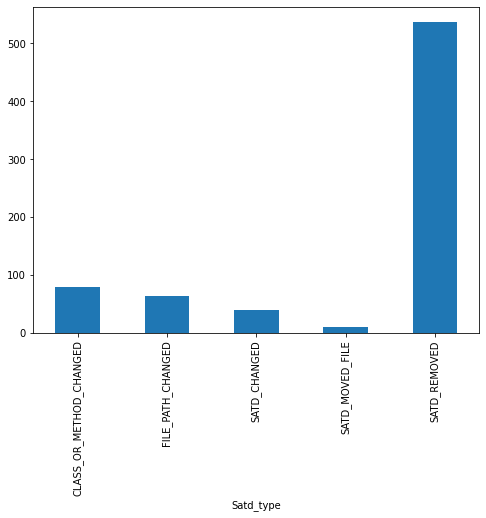

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Satd_type').v1_comment.count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.v1_comment).toarray()
labels = df.category_id
features.shape

(729, 279)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Satd_type, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Satd_type))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'CLASS_OR_METHOD_CHANGED':
  . Most correlated unigrams:
       . extract
       . swimming
  . Most correlated bigrams:
       . plexus utils
       . swimming pool
# 'FILE_PATH_CHANGED':
  . Most correlated unigrams:
       . exception
       . issue
  . Most correlated bigrams:
       . todo need
       . todo filter
# 'SATD_CHANGED':
  . Most correlated unigrams:
       . final
       . file
  . Most correlated bigrams:
       . mime type
       . shouldnt archiver
# 'SATD_MOVED_FILE':
  . Most correlated unigrams:
       . idea
       . determine
  . Most correlated bigrams:
       . ll need
       . support apip
# 'SATD_REMOVED':
  . Most correlated unigrams:
       . issue
       . swimming
  . Most correlated bigrams:
       . todo hv
       . swimming pool


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['v1_comment'], df['Satd_type'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
#print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

In [ ]:
#print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

In [ ]:
#df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

In [ ]:
#df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_weighted'])

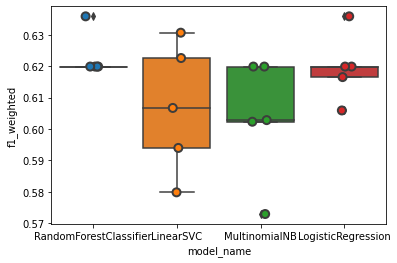

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='f1_weighted', data=cv_df)
sns.stripplot(x='model_name', y='f1_weighted', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').f1_weighted.mean()

model_name
LinearSVC                 0.606776
LogisticRegression        0.619636
MultinomialNB             0.603588
RandomForestClassifier    0.623103
Name: f1_weighted, dtype: float64

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(test_size=0.20,random_state=42,n_splits=1)
X_train, X_test, y_train, y_test = (None, None, None, None)
for train_index, test_index in sss.split(features,labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [ ]:
from sklearn.model_selection import train_test_split

model = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0)

# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=1)

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler
from imblearn.combine import SMOTETomek
from collections import Counter

counter = Counter(y_train)
print("before: ",counter)
smote = SMOTE(random_state=42)
X_train,y_train = smote.fit_resample(X_train,y_train)
counter = Counter(y_train)
print("after: ",counter)

before:  Counter({1: 429, 2: 64, 3: 51, 0: 31, 4: 8})
after:  Counter({1: 429, 3: 429, 2: 429, 0: 429, 4: 429})


In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

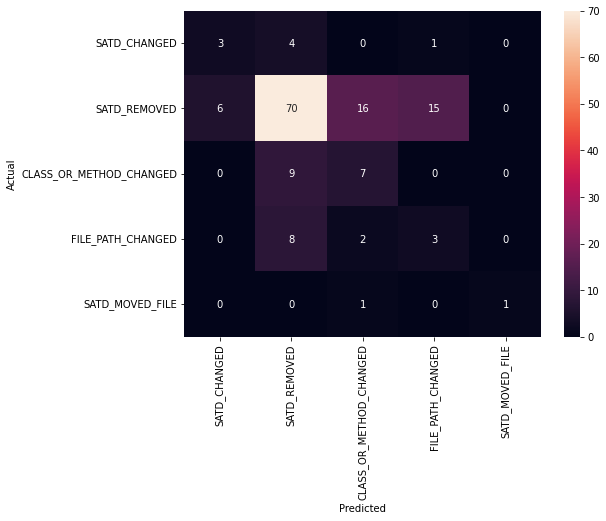

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Satd_type.values, yticklabels=category_id_df.Satd_type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# from IPython.display import display

# for predicted in category_id_df.category_id:
#   for actual in category_id_df.category_id:
#     if predicted != actual and conf_mat[actual, predicted] >= 6:
#       print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
#       display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Satd_type', 'v1_comment']])
#       print('')

In [ ]:
# model.fit(features, labels)

In [ ]:
# from sklearn.feature_selection import chi2

# N = 2
# for Satd_type, category_id in sorted(category_to_id.items()):
#   indices = np.argsort(model.coef_[category_id])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
#   bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
#   print("# '{}':".format(Satd_type))
#   print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
#   print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
texts = ["FIXME throw assertion exception if constraintValidatorType == null",
         "TODO order by sum tag",
         "TODO remove the part with ToolchainManager lookup once we depend on 3.0.9 (have it as prerequisite). Define as regular component field then."]
         
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"FIXME throw assertion exception if constraintValidatorType == null"
  - Predicted as: 'FILE_PATH_CHANGED'

"TODO order by sum tag"
  - Predicted as: 'SATD_REMOVED'

"TODO remove the part with ToolchainManager lookup once we depend on 3.0.9 (have it as prerequisite). Define as regular component field then."
  - Predicted as: 'SATD_REMOVED'

"I have no money to pay my tuition"
  - Predicted as: 'SATD_REMOVED'



In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Satd_type'].unique()))

                         precision    recall  f1-score   support

           SATD_CHANGED       0.33      0.38      0.35         8
           SATD_REMOVED       0.77      0.65      0.71       107
CLASS_OR_METHOD_CHANGED       0.27      0.44      0.33        16
      FILE_PATH_CHANGED       0.16      0.23      0.19        13
        SATD_MOVED_FILE       1.00      0.50      0.67         2

               accuracy                           0.58       146
              macro avg       0.51      0.44      0.45       146
           weighted avg       0.64      0.58      0.60       146

